# Analisis de series de tiempo

Integrantes del trabajo final

Castillo Sebastian (a2004)
Corti Gaston (a2005)

# Ingesta de la informacion

La informacion se obtiene via API del sitio de gobierno la ciudad [Los Angeles](https://data.lacity.org/Public-Safety/Traffic-Collision-Data-from-2010-to-Present/d5tf-ez2w/about_data)

El dataset refleja los incidentes de transito en la Ciudad de Los Angeles desde 2010 hasta marzo de 2025.

Los datos son transcritos de los reportes originales que son elaborados en papel.

El objetivo es desarrollar un modelo que permita estimar la cantidad de incidentes de transito que ocurriran en el futuro.

## Ingesta de informacion via API

In [ ]:
import requests as rq
import json
import pandas as pd
import time

#---------------------------------------------------------
# TRAFIC COLLISION DATA FROM 2010 TO PRESENT (Los Angeles)
#---------------------------------------------------------

# 1) Ingesta de datos desde via API Endpoint

api_ep_la_collisions = 'https://data.lacity.org/resource/d5tf-ez2w.json'

LIMIT = 50000 # Maximum allowed per request (SODA 2.0)
MAX_RETRIES = 3
RETRY_DELAY = 10 # Seconds to wait between attempts

# Storage for the data
la_collisions_data = []
offset = 0
total_retrieved = 0
EXPECTED_TOTAL_ROWS = 621677

print("Starting data retrieval...")

while True:
    retries = 0
    success = False
    last_error_message = ""

    while retries < MAX_RETRIES and not success:
        try:
            params = {'$limit': LIMIT, '$offset': offset}
            response = rq.get(api_ep_la_collisions, params=params)

            if response.status_code == 200:
                chunk = response.json()
                # The condition 'if not chunk:' is redundant as len(chunk) < LIMIT will cover it
                # if the chunk is empty.

                la_collisions_data.extend(chunk)
                retrieved = len(chunk)
                total_retrieved += retrieved
                print(f"✅ Partially ingested {retrieved} rows (Total: {total_retrieved})")
                offset += retrieved
                success = True

            else:
                last_error_message = f"HTTP Error {response.status_code}: {response.text}"
                print(f"⚠️ {last_error_message}. Retrying...")
                retries += 1
                if retries < MAX_RETRIES:
                    time.sleep(RETRY_DELAY)

        except Exception as e:
            last_error_message = f"Exception: {str(e)}"
            print(f"⚠️ {last_error_message}. Retrying...")
            retries += 1
            if retries < MAX_RETRIES:
                time.sleep(RETRY_DELAY)

    if not success:
        print(f"❌ Failed after {MAX_RETRIES} attempts. Stopping. Last error: {last_error_message}")
        break

    # If the retrieved chunk is less than the LIMIT, it means we've reached the end of the data.
    if len(chunk) < LIMIT:
        break

print(f"✅ Final ingestion completed: {len(la_collisions_data)} rows retrieved.")

# Added: Optional: Verify the total number of rows
if len(la_collisions_data) == EXPECTED_TOTAL_ROWS:
    print(f"🎉 Successfully retrieved all {EXPECTED_TOTAL_ROWS} expected rows.")
else:
    print(f"❗ Warning: Expected {EXPECTED_TOTAL_ROWS} rows, but retrieved {len(la_collisions_data)} rows.")

Starting data retrieval...
✅ Partially ingested 50000 rows (Total: 50000)
✅ Partially ingested 50000 rows (Total: 100000)
✅ Partially ingested 50000 rows (Total: 150000)
✅ Partially ingested 50000 rows (Total: 200000)
✅ Partially ingested 50000 rows (Total: 250000)
✅ Partially ingested 50000 rows (Total: 300000)
✅ Partially ingested 50000 rows (Total: 350000)
✅ Partially ingested 50000 rows (Total: 400000)
✅ Partially ingested 50000 rows (Total: 450000)
✅ Partially ingested 50000 rows (Total: 500000)
✅ Partially ingested 50000 rows (Total: 550000)
✅ Partially ingested 50000 rows (Total: 600000)
✅ Partially ingested 21677 rows (Total: 621677)
✅ Final ingestion completed: 621677 rows retrieved.
🎉 Successfully retrieved all 621677 expected rows.


## Transformacion de los datos en un dataframe

In [ ]:
#Transformamos los datos en dataframe utilizando la funcion json_normalize

df_la_collisions = pd.json_normalize(la_collisions_data)

df_la_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621677 entries, 0 to 621676
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   dr_no                        621677 non-null  object
 1   date_rptd                    621677 non-null  object
 2   date_occ                     621677 non-null  object
 3   time_occ                     621677 non-null  object
 4   area                         621677 non-null  object
 5   area_name                    621677 non-null  object
 6   rpt_dist_no                  621677 non-null  object
 7   crm_cd                       621677 non-null  object
 8   crm_cd_desc                  621677 non-null  object
 9   mocodes                      534353 non-null  object
 10  vict_age                     533483 non-null  object
 11  vict_sex                     610980 non-null  object
 12  vict_descent                 610029 non-null  object
 13  premis_cd     

## Perfilado de los datos

In [ ]:
# Mapeo de los tipos de datos

dtype_mapping = {
    'dr_no' : int, # Division of records number : official file number made up of a 2 digit year, area id, and 5 digits
    'time_occ': int,  # In 24 hour military time.
    'area' : 'category', # The lapd has 21 community police stations referred as geographic areas within the department, sequentially numbered from 1 to 21.
    'area_name' : 'category', # The 21 geographic areas name designation that references the landmark or the surrounding community that is responsible for
    'rpt_dist_no' : 'category', # A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons. Find LAPD Reporting Districts on the LA City GeoHub at http://geohub.lacity.org/datasets/c4f83909b81d4786aa8ba8a74a4b4db1_4
    'crm_cd' : 'category', #	Indicates the crime committed. For this dataset - all Crime Code 997
    'crm_cd_desc' : 'category', # Defines the Crime Code provided. For this dataset - all Traffic Collision.
    'mocodes' : 'category', # modus operandi: Activities associated with the suspect in commission of the crime.See attached PDF for list of MO Codes in numerical order. https://data.lacity.org/api/views/y8tr-7khq/files/3a967fbd-f210-4857-bc52-60230efe256c?download:true&filename:MO%20CODES%20(numerical%20order).pdf
    'vict_sex' : 'category', # F - Female M - Male X - Unknown
    'vict_descent' : 'category', # Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian
    'premis_cd' : 'category', # The type of structure or location where the incident took place.
    'premis_desc' : 'category', # Defines the Premise Code provided.
    'location' : 'category',
    'cross_street' : 'category' # Cross Street of rounded Address.
    }

df_la_collisions = df_la_collisions.astype(dtype_mapping) # Transforming attributes detailed in the data dictionary

df_la_collisions[['location_1.latitude','location_1.longitude','vict_age']] = df_la_collisions[['location_1.latitude','location_1.longitude','vict_age']].apply(pd.to_numeric,errors='coerce')

# location_1.latitude : The location where the crime incident occurred.
# location_1.longitude : The location where the crime incident occurred.
# vict_age : victim age - two numeric character

df_la_collisions['date_occ'] = pd.to_datetime(df_la_collisions['date_occ'],errors='coerce')
df_la_collisions['date_rptd'] = pd.to_datetime(df_la_collisions['date_rptd'],errors='coerce').dt.normalize()

df_la_collisions.info()

df_la_collisions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621677 entries, 0 to 621676
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   dr_no                        621677 non-null  int64         
 1   date_rptd                    621677 non-null  datetime64[ns]
 2   date_occ                     621677 non-null  datetime64[ns]
 3   time_occ                     621677 non-null  int64         
 4   area                         621677 non-null  category      
 5   area_name                    621677 non-null  category      
 6   rpt_dist_no                  621677 non-null  category      
 7   crm_cd                       621677 non-null  category      
 8   crm_cd_desc                  621677 non-null  category      
 9   mocodes                      534353 non-null  category      
 10  vict_age                     533483 non-null  float64       
 11  vict_sex                  

,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,crm_cd,crm_cd_desc,mocodes,...,cross_street,:@computed_region_qz3q_ghft,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,location_1.latitude,location_1.longitude,location_1.human_address
0,212013850,2021-09-03,2021-09-02,2335,20,Olympic,2021,997,TRAFFIC COLLISION,3004 3027 3034 4027 3036 3101 3401 3701,...,6TH ST,22722,588,875,36,7,86,34.0630,-118.3141,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
1,221417787,2022-10-17,2022-10-17,1620,14,Pacific,1406,997,TRAFFIC COLLISION,4027 3011 3028 3034 3037 3101 3401 3701,...,MOTOR AV,23451,881,1358,9,6,74,34.0290,-118.4113,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
2,221418141,2022-10-26,2022-10-26,1135,14,Pacific,1434,997,TRAFFIC COLLISION,4027 3011 3025 3034 3037 3101 3401 3701,...,ROSEWOOD AV,24031,891,855,10,10,27,34.0052,-118.4478,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
3,222017859,2022-12-01,2022-12-01,230,20,Olympic,2044,997,TRAFFIC COLLISION,3003 0913 3026 3035 3037 3101 3401 3701 4020,...,SAN MARINO ST,22723,607,647,NaN,12,89,34.0545,-118.3009,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
4,190319651,2019-08-24,2019-08-24,450,03,Southwest,0356,997,TRAFFIC COLLISION,3036 3004 3026 3101 4003,...,NORMANDIE AV,22724,691,916,7,14,32,34.0255,-118.3002,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."


## Seleccion de columnas deseadas para el modelo e indexacion del dataframe

In [ ]:
df_la_collisions_eda = df_la_collisions[['dr_no',
                                        'time_occ',
                                        'date_rptd',
                                         'area',
                                         'area_name',
                                         'vict_sex',
                                         'vict_descent',
                                         'vict_age']]

# --------------------------------------
# DATE data types treatment + Indexing
# --------------------------------------

# 1. Convert datetime columns and set 'date_occ' as index, dropping the original column
df_la_collisions_eda = df_la_collisions_eda.set_index(df_la_collisions['date_occ'], drop=True).sort_index()

# 2. Normalize the datetime index (remove time component if not needed)
df_la_collisions_eda.index = df_la_collisions_eda.index.normalize()

# 3. Create time-based features from the index
df_la_collisions_eda['year'] = df_la_collisions_eda.index.year
df_la_collisions_eda['month'] = df_la_collisions_eda.index.month
df_la_collisions_eda['day_of_week'] = df_la_collisions_eda.index.dayofweek  # Monday=0, Sunday=6
df_la_collisions_eda['is_weekend'] = df_la_collisions_eda.index.dayofweek >= 5

## Tratamiento de valores faltantes

In [ ]:
# Empezamos por obtener en un data frame la cantidad de información faltante de cada columna de los datos de entrenamiento

missing_data = df_la_collisions_eda.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

,0
vict_age,88194
vict_descent,11648
vict_sex,10697


In [ ]:
# Percentage of missing values within each column [Set de prueba]

df_la_collisions_eda.isna().mean().round(4)*100

,0
dr_no,0.00
time_occ,0.00
date_rptd,0.00
area,0.00
area_name,0.00
vict_sex,1.72
vict_descent,1.87
vict_age,14.19
year,0.00
month,0.00


<Axes: >

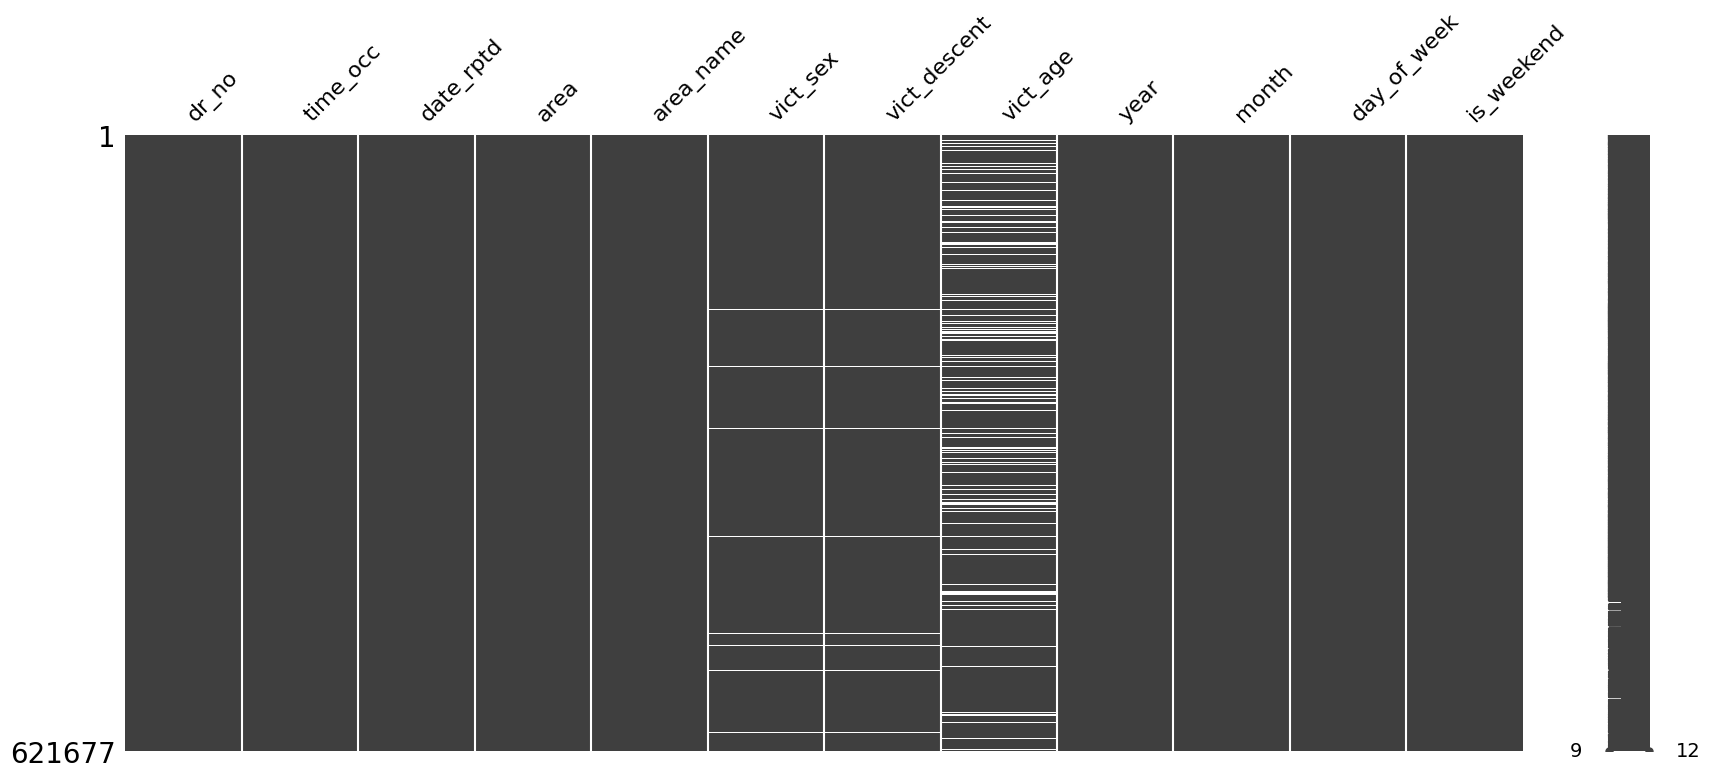

In [ ]:
# Matriz de valores faltantes
import missingno as msno

# Matriz de valores faltantes
msno.matrix(df_la_collisions_eda, figsize=(20,8))

In [ ]:
# For numerical columns (vict_age)
vict_age_mean = df_la_collisions_eda['vict_age'].mean()
df_la_collisions_eda['vict_age'].fillna(vict_age_mean, inplace=True)

# For categorical columns
# Define columns and their missing value indicators
missing_values_map = {
    'vict_sex': 'X',  # Will be maintained as existing category
    'vict_descent': 'X'  # Will be maintained as existing category
}

# Process each categorical column
for col, fill_value in missing_values_map.items():
    if pd.api.types.is_categorical_dtype(df_la_collisions_eda[col]):
        # Check if fill_value is not already a category
        if fill_value not in df_la_collisions_eda[col].cat.categories:
            df_la_collisions_eda[col] = df_la_collisions_eda[col].cat.add_categories(fill_value)

    # Fill NA values
    df_la_collisions_eda[col] = df_la_collisions_eda[col].fillna(fill_value)

<ipython-input-33-1053690149>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_la_collisions_eda['vict_age'].fillna(vict_age_mean, inplace=True)
<ipython-input-33-1053690149>:14: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_la_collisions_eda[col]):


In [ ]:
# Chequeando nulos despues del tratamiento

missing_data = df_la_collisions_eda.isnull().sum(axis = 0) #Generamos matriz booleana y sumamos los valores True por columnas
missing_data = missing_data[missing_data>0] #Filtramos las columnas con algún dato faltante
missing_data.sort_values(ascending = False) #Ordenamos las columnas

,0


In [ ]:
df_la_collisions_eda.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 621677 entries, 2010-01-01 to 2025-03-08
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   dr_no         621677 non-null  int64         
 1   time_occ      621677 non-null  int64         
 2   date_rptd     621677 non-null  datetime64[ns]
 3   area          621677 non-null  category      
 4   area_name     621677 non-null  category      
 5   vict_sex      621677 non-null  category      
 6   vict_descent  621677 non-null  category      
 7   vict_age      621677 non-null  float64       
 8   year          621677 non-null  int32         
 9   month         621677 non-null  int32         
 10  day_of_week   621677 non-null  int32         
 11  is_weekend    621677 non-null  bool          
dtypes: bool(1), category(4), datetime64[ns](1), float64(1), int32(3), int64(2)
memory usage: 33.8 MB


# Seleccion de datos de prueba y datos de entrenamiento

Train size: 4436 (80.0%)
Test size: 1110 (20.0%)
Train date range: 2010-01-01 00:00:00 to 2022-02-22 00:00:00
Test date range:  2022-02-23 00:00:00 to 2025-03-08 00:00:00


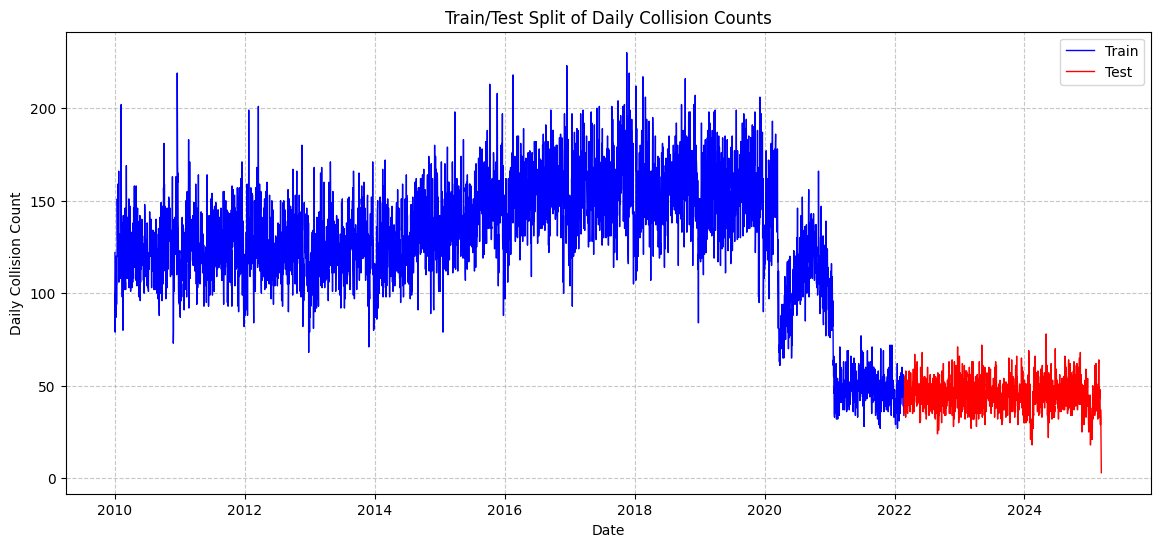

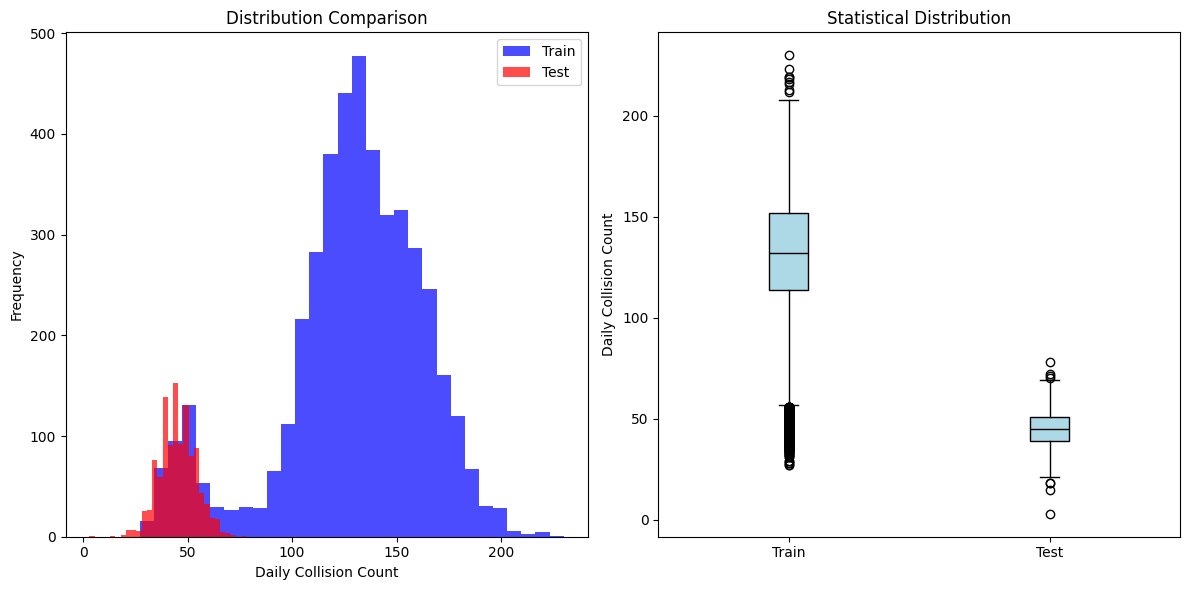

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# STEP 1: Prepare Time Series Data. Aggregate the data into daily collision counts (current data has multiple entries per day):

# Resample to daily frequency and count collisions per day
df_daily = df_la_collisions_eda.resample('D').size().rename('collision_count')

#STEP 2: Train-Test Split (80/20). Split temporally (time-series data must maintain order):

# Spliting data sets using a ratio (80% train, 20% test)

split_ratio = 0.8
split_idx = int(len(df_daily) * split_ratio)
train = df_daily.iloc[:split_idx]
test = df_daily.iloc[split_idx:]

# Verifying split sizes
print(f"Train size: {len(train)} ({len(train)/len(df_daily):.1%})")
print(f"Test size: {len(test)} ({len(test)/len(df_daily):.1%})")

# Verifying date range for both train and test data sets
print(f"Train date range: {train.index.min()} to {train.index.max()}")
print(f"Test date range:  {test.index.min()} to {test.index.max()}")

# Visualizing the split
plt.figure(figsize=(14, 6))
plt.plot(train.index, train.values, 'b-', label='Train', linewidth=1)
plt.plot(test.index, test.values, 'r-', label='Test', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Daily Collision Count')
plt.title('Train/Test Split of Daily Collision Counts')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Alternative visualization

plt.figure(figsize=(12, 6))

# Histogram of collision counts
plt.subplot(1, 2, 1)
plt.hist(train.values, bins=30, color='blue', alpha=0.7, label='Train')
plt.hist(test.values, bins=30, color='red', alpha=0.7, label='Test')
plt.xlabel('Daily Collision Count')
plt.ylabel('Frequency')
plt.title('Distribution Comparison')
plt.legend()

# Box plot comparison
plt.subplot(1, 2, 2)
plt.boxplot([train.values, test.values],
            tick_labels=['Train', 'Test'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='black'))
plt.ylabel('Daily Collision Count')
plt.title('Statistical Distribution')

plt.tight_layout()
plt.show()
